In [15]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


In [2]:
# Load the new training and test datasets
train_data_path = r'C:\Users\HP\Desktop\Credit_risk\final_application_train.csv'
test_data_path = r'C:\Users\HP\Desktop\Credit_risk\final_application_test.csv'

X_train_selected = pd.read_csv(train_data_path)
X_test_selected = pd.read_csv(test_data_path)

# Save SK_ID_CURR for the test set
test_ids = X_test_selected['SK_ID_CURR']

# Ensure 'SK_ID_CURR' is not in the feature set
X_train_selected = X_train_selected.drop(columns=['SK_ID_CURR'])
X_test_selected = X_test_selected.drop(columns=['SK_ID_CURR'])

In [3]:
# Clean feature names to remove special JSON characters
def clean_feature_names(df):
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
    return df

X_train_selected = clean_feature_names(X_train_selected)
X_test_selected = clean_feature_names(X_test_selected)


In [4]:
# Define features and target
X = X_train_selected.drop(columns=['TARGET'])
y = X_train_selected['TARGET']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Define the parameter grid
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10],
    'feature_fraction': [0.8, 0.9, 1.0]
}

# Create the LightGBM model
lgb_estimator = lgb.LGBMClassifier(objective='binary', metric='auc')

# Perform grid search
grid_search = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters
print(f'Best parameters found: {grid_search.best_params_}')


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.428265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53433
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 255
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [8]:
# Train the model with the best parameters
best_params = grid_search.best_params_

lgb_model = lgb.train(
    best_params,
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=5000,
    valid_sets=[lgb.Dataset(X_val, label=y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
)

# Predict on the validation set
y_val_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

# Evaluate the model
val_auc = roc_auc_score(y_val, y_val_pred)
print(f'Validation AUC: {val_auc:.4f}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.322041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53433
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 255
[LightGBM] [Info] Start training from score 0.080794
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [11]:
# Perform k-fold cross-validation
cv_scores = cross_val_score(lgb.LGBMClassifier(**best_params), X, y, cv=5, scoring='roc_auc')
print(f'Cross-validation AUC scores: {cv_scores}')
print(f'Mean AUC: {cv_scores.mean():.4f}')


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.352644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53348
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 255
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

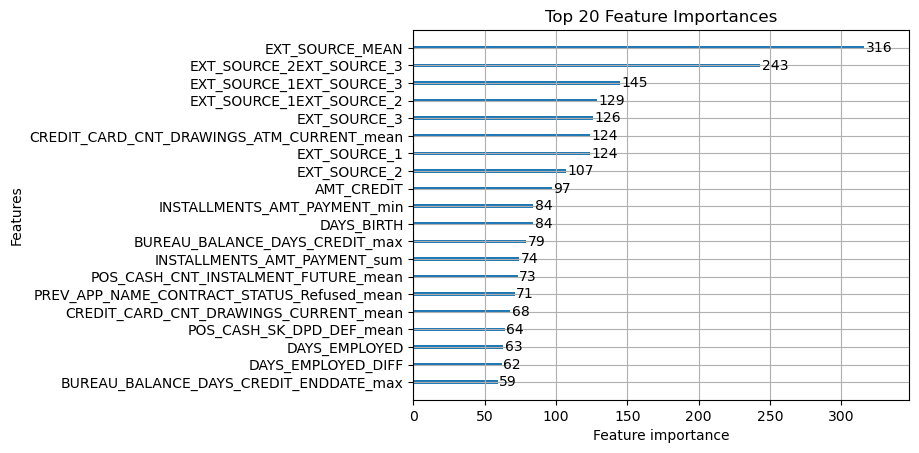

In [14]:
# Plot feature importance
lgb.plot_importance(lgb_model, max_num_features=20)
plt.title('Top 20 Feature Importances')
plt.show()


In [12]:
# Retrain the model on the entire training dataset
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X, y)


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.564713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53441
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 255
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

LGBMClassifier(feature_fraction=1.0, max_depth=5)

In [13]:
# Make predictions on the test dataset
test_predictions = final_model.predict_proba(X_test_selected)[:, 1]


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0


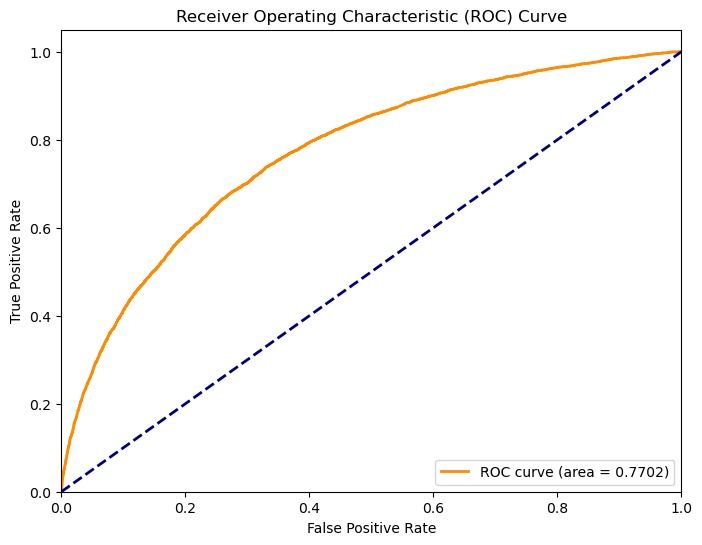

In [16]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
